In [92]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [ ]:
AAPL = pd.read_csv("/content/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("/content/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("/content/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("/content/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("/content/Pre_Processed_AMZN.csv")

### Data Proprocessing

In [93]:
def Dataset(Data, Date):

  normaliser = preprocessing.MinMaxScaler()

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  

  Data_Train = normaliser.fit_transform(Data_Train)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test = normaliser.transform(Data_Test)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [94]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(300, dropout=0.2, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    #model.add(Dropout(0.4))
    #model.add(LSTM(units=200,dropout=0.4))  
  return model

In [95]:
model = Model()

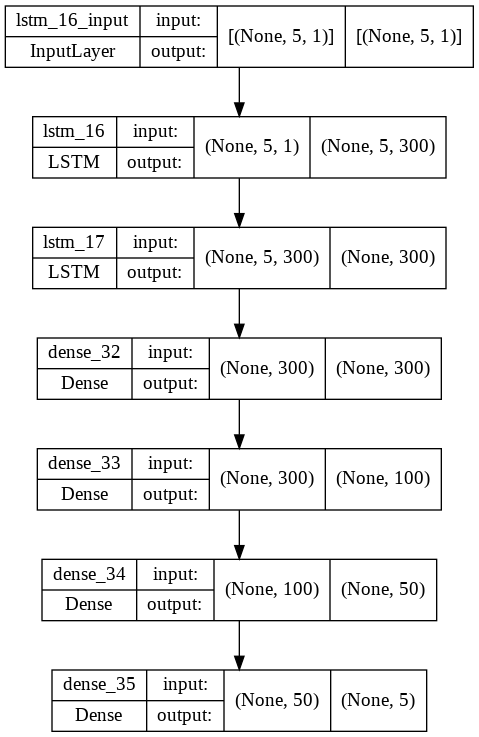

In [96]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 300)            362400    
                                                                 
 lstm_17 (LSTM)              (None, 300)               721200    
                                                                 
 dense_32 (Dense)            (None, 300)               90300     
                                                                 
 dense_33 (Dense)            (None, 100)               30100     
                                                                 
 dense_34 (Dense)            (None, 50)                5050      
                                                                 
 dense_35 (Dense)            (None, 5)                 255       
                                                                 
Total params: 1,209,305
Trainable params: 1,209,305
No

### Custom Learning Rate

In [103]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

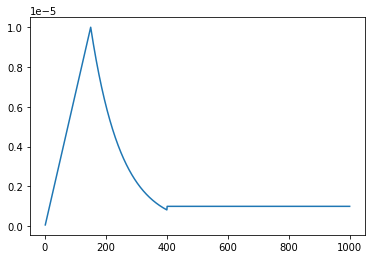

In [104]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [105]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple

In [106]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [107]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [108]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [109]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [110]:
AAPL_Model = Model()

In [111]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [112]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 3s 118ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812 - val_loss: 0.9411 - val_root_mean_squared_error: 0.9701 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812 - val_loss: 0.9411 - val_root_mean_squared_error: 0.9701 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812 - val_loss: 0.9411 - val_root_mean_squared_error: 0.9701 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812 - val_loss: 0.9410 - val_root_mean_squared_error: 0.9700 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 1s 62ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812 - val_loss: 0.9409 - val_root_mean_squared_error: 0.9700 - lr: 2.6667e-07
Epoch 6/1000
9/9 [==============================] - 1s 67ms

In [113]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

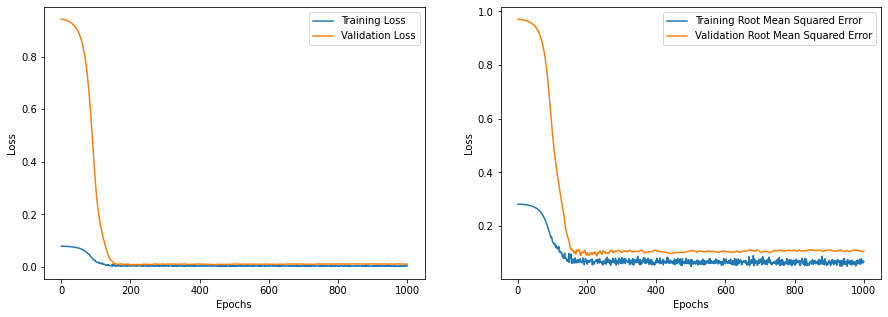

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [115]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

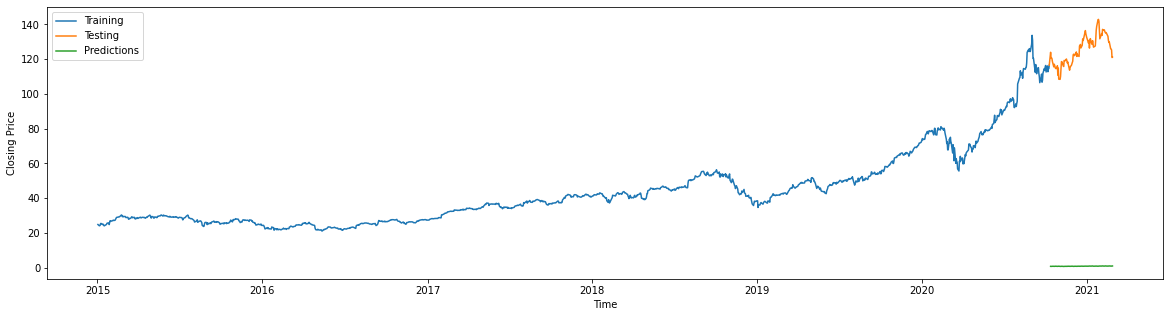

In [116]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [117]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 0.10625194027211096
MAPE: 0.0982341549884384


#Tesla

In [118]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [119]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [120]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [121]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Model Fitting

In [ ]:
TSLA_Model = Model()

In [ ]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [122]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 0s 41ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 40ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426 - lr: 2.6667e-07
Epoch 6/200
9/9 [==============================] - 0s 40ms/step -

In [124]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

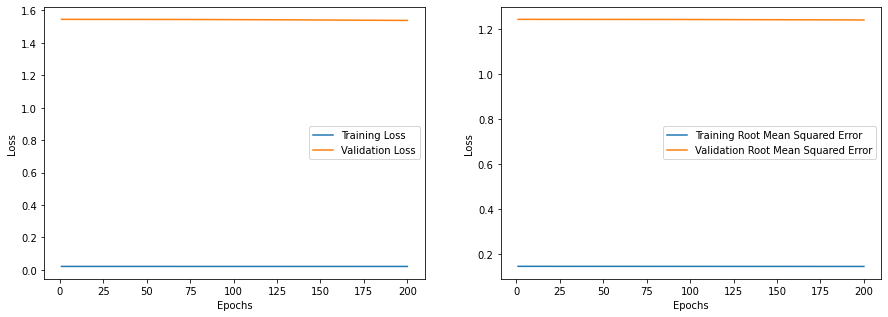

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Tesla

In [126]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

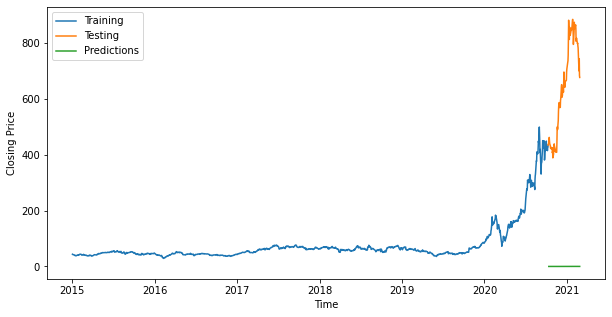

In [127]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [128]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 1.239878807886411
MAPE: 0.8492705463200066


#Google

In [129]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [141]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [142]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [143]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Model Fitting

In [144]:
GOOG_Model = Model()

In [145]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [146]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/1000
10/10 [==============================] - 4s 111ms/step - loss: 0.2350 - root_mean_squared_error: 0.4847 - val_loss: 1.3666 - val_root_mean_squared_error: 1.1690 - lr: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848 - val_loss: 1.3666 - val_root_mean_squared_error: 1.1690 - lr: 6.6667e-08
Epoch 3/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848 - val_loss: 1.3665 - val_root_mean_squared_error: 1.1690 - lr: 1.3333e-07
Epoch 4/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848 - val_loss: 1.3664 - val_root_mean_squared_error: 1.1689 - lr: 2.0000e-07
Epoch 5/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.2349 - root_mean_squared_error: 0.4847 - val_loss: 1.3663 - val_root_mean_squared_error: 1.1689 - lr: 2.6667e-07
Epoch 6/1000
10/10 [=============================

In [148]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

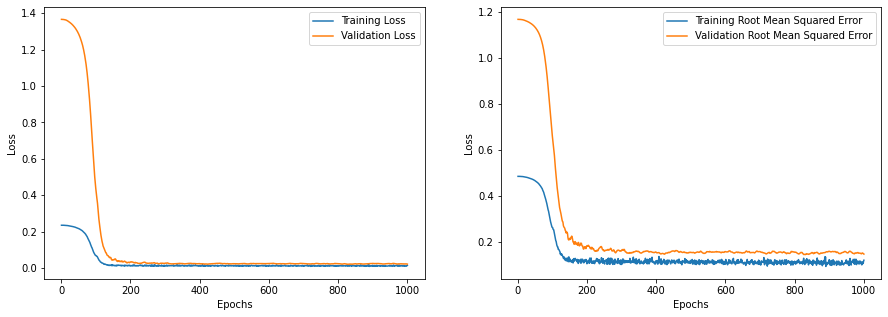

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Google

In [150]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

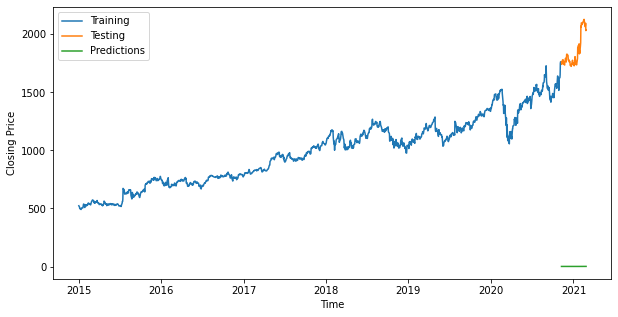

In [151]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [152]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 0.1459313018894264
MAPE: 0.11361470739355094


#Microsoft

In [169]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [170]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [171]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [156]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Model Fitting

In [157]:
MSFT_Model = Model()

In [158]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [159]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 3s 117ms/step - loss: 0.1458 - root_mean_squared_error: 0.3818 - val_loss: 0.9400 - val_root_mean_squared_error: 0.9695 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.1458 - root_mean_squared_error: 0.3818 - val_loss: 0.9400 - val_root_mean_squared_error: 0.9695 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.1458 - root_mean_squared_error: 0.3818 - val_loss: 0.9400 - val_root_mean_squared_error: 0.9695 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.1458 - root_mean_squared_error: 0.3818 - val_loss: 0.9399 - val_root_mean_squared_error: 0.9695 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 1s 63ms/step - loss: 0.1457 - root_mean_squared_error: 0.3818 - val_loss: 0.9398 - val_root_mean_squared_error: 0.9694 - lr: 2.6667e-07
Epoch 6/1000
9/9 [==============================] - 1s 64ms

In [172]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

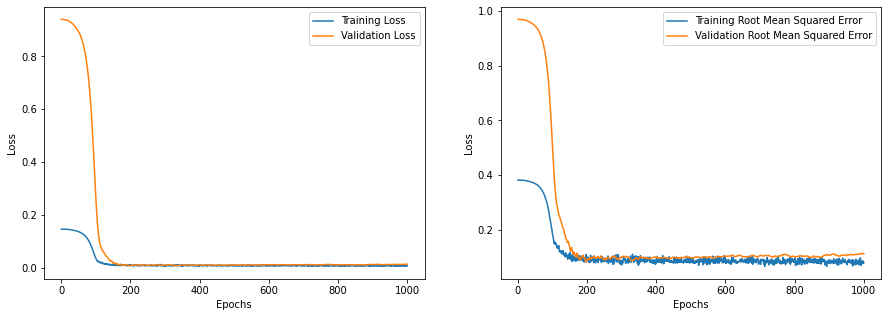

In [173]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Microsoft

In [174]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

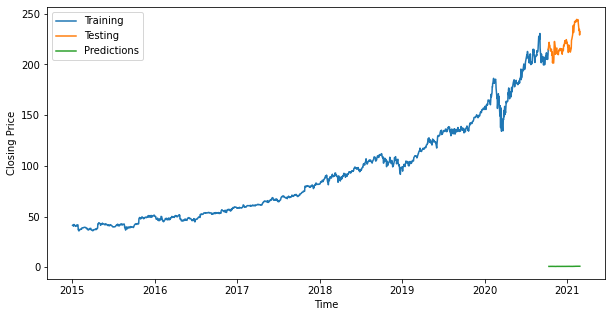

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [176]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 0.11206558148909268
MAPE: 0.10817920656633258


#Amazon

In [177]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [178]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [179]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [180]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Model Fitting

In [181]:
AMZN_Model = Model()

In [182]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [183]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 200, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 5s 195ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.8388 - val_root_mean_squared_error: 0.9159 - lr: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 1s 63ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.8388 - val_root_mean_squared_error: 0.9158 - lr: 6.6667e-08
Epoch 3/200
10/10 [==============================] - 1s 61ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.8387 - val_root_mean_squared_error: 0.9158 - lr: 1.3333e-07
Epoch 4/200
10/10 [==============================] - 1s 60ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.8386 - val_root_mean_squared_error: 0.9158 - lr: 2.0000e-07
Epoch 5/200
10/10 [==============================] - 1s 60ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.8386 - val_root_mean_squared_error: 0.9157 - lr: 2.6667e-07
Epoch 6/200
10/10 [==============================] - 1

In [184]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

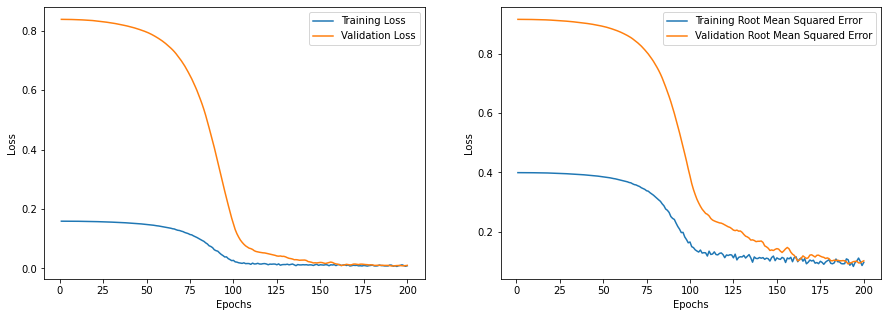

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Amazon

In [186]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

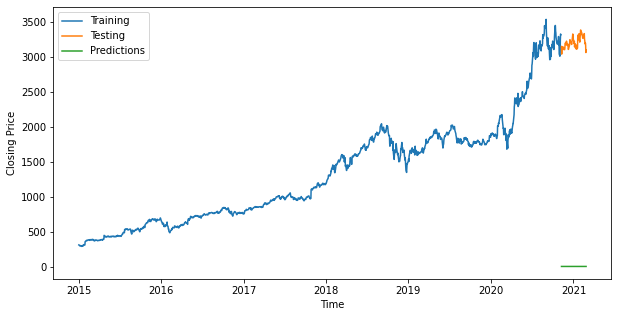

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [189]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 0.10163103968206341
MAPE: 0.10711587362554968
